<font size="7"><span style="color:green">Librerías

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import AdaBoostClassifier 


import xgboost
    # NOTA
    # xgboost.XGBRFClassifier En cada secuencia tiene un RandomForest
    # xgboost.XGBClassifier sin RandomForest

# ------------------

# Pipeline
from sklearn.pipeline import Pipeline
    # NOTA
    # Hay que poner las etiquetas automáticamente. El otro es 'from sklearn.pipeline import make_pipeline'

# ------------------

# Métricas de validación
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
# ------------------

# GridSearch
from sklearn.model_selection import GridSearchCV

# ------------------

# Balanceo
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# ------------------

# Otras
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split


In [2]:
# LECTURA CSV
vinos = pd.read_csv('data/winequalityN.csv')

In [3]:
# SEED
seed=33

In [4]:
# Hacemos otro df con sólo los vinos blancos
tinto=vinos[vinos['type']=='red'].reset_index()
tinto = tinto.drop(['index', 'type'], axis=1)

In [5]:
# Nos deshacemos de los valores nulos
tinto = tinto.dropna()

In [6]:
# Cambiamos la variable Target para que sea solo entre 'aptos=1' y 'no aptos=0'
my_dict={3:0, 4:0, 5:0,
        6:1, 7:1, 8:1}
tinto['apto']= tinto['quality'].map(my_dict)
tinto = tinto.drop(['quality'], axis=1)

Value Counts  1    0.534212
0    0.465788
Name: apto, dtype: float64


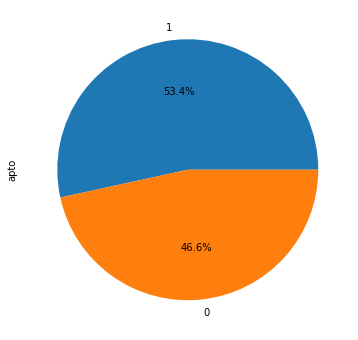

In [7]:
#  Ver el balance de los datos
print('Value Counts ', tinto['apto'].value_counts(normalize=True))
plt.figure(figsize=(10,6))
tinto['apto'].value_counts().plot.pie(autopct="%.1f%%");

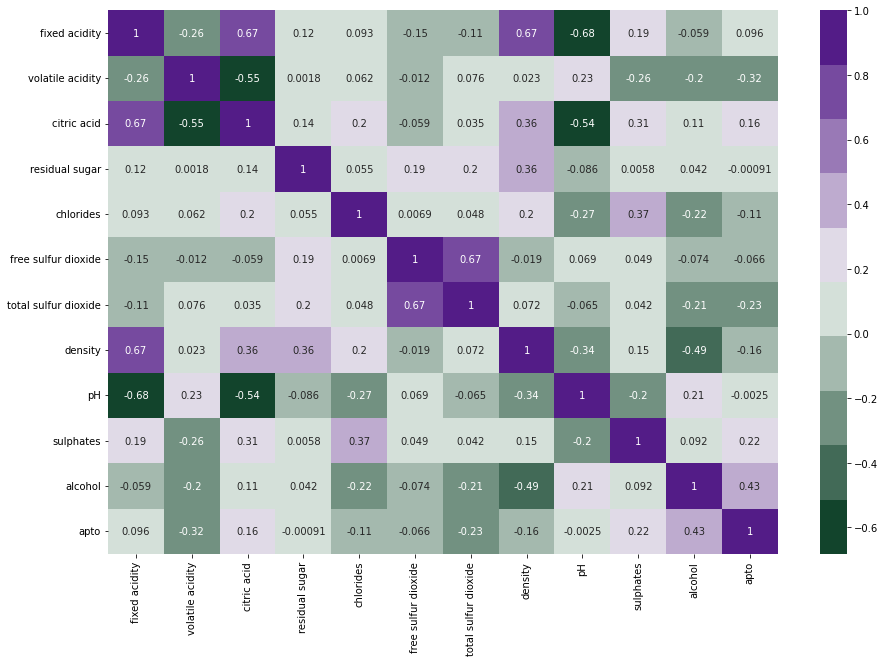

In [8]:
# Heatmap para ver la correlación de los datos
plt.figure(figsize=(15,10))
sns.heatmap(tinto.corr(),cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10), annot=True);

In [9]:
# Quitamos la variable 'densidad', ya que depende del azucar y del alcohol.

# He probado a quitar 'free sulfur dioxide', porque depende de 'total sulfur dioxide', pero se ve que hay algo más que influye en ella,
# y el modelo predice mejor si la dejamos

X = tinto[['volatile acidity','residual sugar',
       'chlorides','total sulfur dioxide',
        'sulphates', 'alcohol']]
y = tinto['apto']

In [10]:
# Balanceo ROS
ros = RandomOverSampler(random_state=seed)
X_ros, y_ros = ros.fit_resample(X, y)


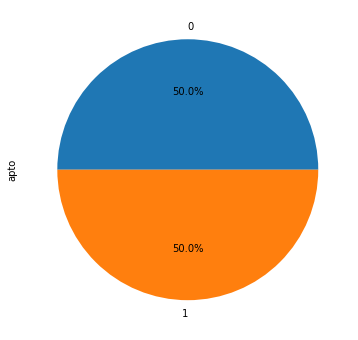

In [11]:
# Vemos el nuevo balance de los datos.
plt.figure(figsize=(10,6))
y_ros.value_counts().plot.pie(autopct="%.1f%%");


In [12]:
# Entrenamiento tras el balanceo. Al agregar el stratify he ganado otro 1%
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.2,stratify=y_ros, random_state=seed)

In [13]:
# Pipeline
pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('kbest', SelectKBest()),
                       ('classifier', LogisticRegression(random_state=seed))])

Best model. Best Score 0.8023585624309142 
 --------------------------------------------------
Best model. Best Params {'classifier': GradientBoostingClassifier(learning_rate=0.35, max_depth=6, n_estimators=300), 'classifier__learning_rate': 0.35, 'classifier__max_depth': 6, 'classifier__n_estimators': 300, 'kbest__k': 6} 
 --------------------------------------------------
Accuracy Score 0.8826979472140762 
 --------------------------------------------------
Confusion Matrix 
 [[154  17]
 [ 23 147]] 
 --------------------------------------------------


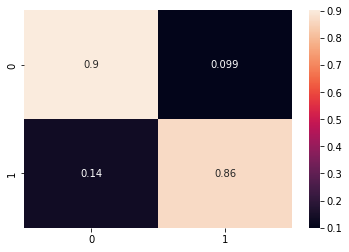

In [14]:
# GridSearch. Dejo solo el GradientBoostingClassifier con 'max_depth=5' porque es el que mejor resultado me ha dado

# svm_params = {'kbest__k': [5,7,8,9],
#               'classifier': [SVC()],
#               'classifier__C': [0.5,0.8,1],
#               'classifier__kernel': ['linear','rbf','sigmoid']
# }

# log_params = {'kbest__k': [5,7,8,9],
#               'classifier': [LogisticRegression()],
#               'classifier__penalty': ['l1','l2'],
#               'classifier__C': np.logspace(0,2,5)
# }

# knn_params = {'kbest__k': [5,7,8,9],
#               'classifier': [KNeighborsClassifier()],
#               'classifier__n_neighbors': [5,10,12,17,20],
#               'classifier__weights': ['uniform','distance']
# }

# rf_params = {'kbest__k': [5,7,8,9],
#               'classifier': [RandomForestClassifier()],
#               'classifier__n_estimators': [50,100,150],
#               'classifier__max_depth': [2,3,4,5,6,7],
#               'classifier__min_samples_leaf': [1,3,5]
# }

gb_params = {'kbest__k': [4,5,6],
              'classifier': [GradientBoostingClassifier()],
            #   'classifier__max_depth': [2,3,4,5,6],
              'classifier__max_depth': [5,6,7,8],
              'classifier__n_estimators': [200,250,300,450],
              'classifier__learning_rate': [0.1,0.15,0.2,0.25,0.3,0.35]
}

# ada_params = {'kbest__k': [7,8,9],
#               'classifier': [AdaBoostClassifier()],
#               'classifier__n_estimators': [150,200,300,350],
#               'classifier__learning_rate': [0.3,0.5,0.7,1]
# }

# xgb_params = {'kbest__k': [7,8,9],
#               'classifier': [xgboost.XGBRFClassifier()],
#               'classifier__n_estimators': [175,200,225],
#               'classifier__learning_rate': [0.01,0.02,0.03,0.05]
# }

# search_space = [svm_params, log_params, knn_params, rf_params, gb_params, ada_params, xgb_params]
search_space = [gb_params]

clf = GridSearchCV(estimator=pipe, param_grid=search_space, cv=3, n_jobs=-1)
best_model = clf.fit(X_train, y_train)

y_pred = best_model.best_estimator_.predict(X_test)

print('Best model. Best Score', best_model.best_score_, '\n','-'*50)
print('Best model. Best Params', best_model.best_params_, '\n','-'*50)
print('Accuracy Score', accuracy_score(y_test, y_pred), '\n','-'*50)
print('Confusion Matrix \n', confusion_matrix(y_test,y_pred), '\n','-'*50)
sns.heatmap(confusion_matrix(y_test,y_pred, normalize='true'), annot=True);